In [1]:
pwd = %pwd

import os, sys
sys.path.insert(0, os.path.join(pwd, "../"))


#

-------

自作環境を用意するには 'srl.base.env.EnvBase' を継承して作ります。  
ただ、作りたい環境によってはいらない情報もあるので、  
'srl.base.env.genre'に各環境に合わせたインタフェースも用意しています。  


ここでは一人プレイでアクションと状態が共に離散値を取る環境を作成していきます。  
'srl.base.env.genre.singleplay.SinglePlayEnv' を継承してクラスを作っていきます。

以下のプロパティと関数が最低限必要となります。

``` python
from typing import Any, List, Tuple, cast

import numpy as np
from srl.base.env.genre import SinglePlayEnv
from srl.base.define import EnvObservationType
from srl.base.env.base import SpaceBase

class MyEnv(SinglePlayEnv):

    # アクションの形式を返す（後述）
    @property
    def action_space(self) -> SpaceBase:
        raise NotImplementedError()

    # 状態の形式を返す（後述）
    @property
    def observation_space(self) -> SpaceBase:
        raise NotImplementedError()

    # 環境の種類を指定
    @property
    def observation_type(self) -> EnvObservationType:
        raise NotImplementedError()
    
    # 1エピソードの最大ターン数
    @property
    def max_episode_steps(self) -> int:
        raise NotImplementedError()

    # エピソードの最初に呼ばれる関数
    # 初期状態を返す
    def call_reset(self) -> np.ndarray:
        raise NotImplementedError()

    # 1stepの関数
    # アクションを受け取り、1step進めて、[状態,報酬,終わりか,情報]を返す
    def call_step(self, action: int) -> Tuple[np.ndarray, float, bool, dict]:
        raise NotImplementedError()
    
    # backup/restoreで環境の状態を保存・復元できるように関数を作る
    def backup(self) -> Any:
        raise NotImplementedError()
    def restore(self, data: Any) -> None:
        raise NotImplementedError()

```


実際に作ってみます。

In [2]:
import enum
from dataclasses import dataclass
from typing import Any, Tuple

import numpy as np
from srl.base.define import EnvObservationType
from srl.base.env.base import SpaceBase
from srl.base.env.genre.singleplay import SinglePlayEnv
from srl.base.env.spaces import BoxSpace, DiscreteSpace


class Action(enum.Enum):
    LEFT = 0
    RIGHT = 1


@dataclass
class MyEnv(SinglePlayEnv):

    move_reward: float = -0.04

    def __post_init__(self):
        self.field = [-1, 0, 0, 0, 0, 0, 0, 0, 1]

    @property
    def action_space(self) -> SpaceBase:
        return DiscreteSpace(len(Action))

    @property
    def observation_space(self) -> SpaceBase:
        return BoxSpace(
            low=0,
            high=len(self.field),
            shape=(1,),
        )

    @property
    def observation_type(self) -> EnvObservationType:
        return EnvObservationType.DISCRETE

    @property
    def max_episode_steps(self) -> int:
        return 20

    def call_reset(self) -> np.ndarray:
        self.player_pos = 4
        return np.array(self.player_pos)

    def call_step(self, action_: int) -> Tuple[np.ndarray, float, bool, dict]:
        action = Action(action_)

        if action == Action.LEFT:
            self.player_pos -= 1
        elif action == Action.RIGHT:
            self.player_pos += 1

        if self.field[self.player_pos] == -1:
            return np.array(self.player_pos), -1, True, {}

        if self.field[self.player_pos] == 1:
            return np.array(self.player_pos), 1, True, {}

        return np.array(self.player_pos), self.move_reward, False, {}

    def backup(self) -> Any:
        return self.player_pos

    def restore(self, data: Any) -> None:
        self.player_pos = data

    def render_terminal(self):
        s = ""
        for x in range(len(self.field)):
            if x == self.player_pos:
                s += "P"
            elif self.field[x] == -1:
                s += "X"
            elif self.field[x] == 1:
                s += "G"
            else:
                s += "."
        print(s)
        

c:\Users\poco\venv\rl39-gpu\lib\site-packages\flatbuffers\compat.py:19: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp
c:\Users\poco\venv\rl39-gpu\lib\site-packages\keras\utils\image_utils.py:36: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  'nearest': pil_image.NEAREST,
c:\Users\poco\venv\rl39-gpu\lib\site-packages\keras\utils\image_utils.py:37: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  'bilinear': pil_image.BILINEAR,
c:\Users\poco\venv\rl39-gpu\lib\site-packages\keras\utils\image_utils.py:38: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  'bicubic': pil_image.BICUBIC,
c:\Users\poco\venv\rl39-gpu\lib\site-packages\keras\utils\image_utils.py:39: Depr

'SpaceBase' は現状5種類あります。(コードは `srl.base.env.spaces` を見てください)

+ DiscreteSpace  
1つの整数を表します。  
例えば DiscreteSpace(5) とした場合、0～4 の値を取ります。  

+ ArrayDiscreteSpace  
整数の配列を取ります。  
例えば ArrayDiscreteSpace([3, 2]) とした場合、[0, 0] や [2, 1] 等の値を取ります。  

+ ContinuousSpace  
1つの小数を表します。  
例えば ContinuousSpace(-1, 1) とした場合、-1～1 の値を取ります。  

+ ArrayContinuousSpace  
小数の配列を取ります。  
例えば ArrayContinuousSpace(3, -1, 1) とした場合、[0.1, -0.5, 0.9] 等の値を取ります。  

+ BoxSpace  
numpy配列を指定の範囲内で取り扱います。（np.ndarray型）  
例えば BoxSpace(shape=(1, 2), low=-1, high=1) とした場合、[[-0.1, 1.0]] や [[0.1, 0.2] 等の値を取ります。  




作成出来たら登録します。  
引数は以下です。  

``` python
id: ユニークな名前  
entry_point: __name__ + ":" + クラス名  
kwargs: クラス生成時の引数
```

In [3]:
from srl.base.env import registration

registration.register(
    id="MyEnv",
    entry_point=__name__ + ":MyEnv",
    kwargs={
        "move_reward": -0.04,
    },
)


以下のように実行できます。  
'SinglePlayEnvWrapper' を通すとシングルプレイ用のインタフェースで実行できます。


In [4]:
import srl
from srl.base.env.singleplay_wrapper import SinglePlayEnvWrapper

env = srl.envs.make("MyEnv")
env = SinglePlayEnvWrapper(env)  # change single play interface

state = env.reset()
done = False
total_reward = 0
step = 0
env.render()

while not done:
    action = env.sample()
    state, reward, done, info = env.step(action)
    total_reward += reward
    step += 1
    print(f"step {step}, action {action}, reward {reward}, done {done}")
    env.render()

print(total_reward)



X...P...G
step 1, action 1, reward -0.04, done False
X....P..G
step 2, action 1, reward -0.04, done False
X.....P.G
step 3, action 0, reward -0.04, done False
X....P..G
step 4, action 1, reward -0.04, done False
X.....P.G
step 5, action 0, reward -0.04, done False
X....P..G
step 6, action 0, reward -0.04, done False
X...P...G
step 7, action 0, reward -0.04, done False
X..P....G
step 8, action 1, reward -0.04, done False
X...P...G
step 9, action 0, reward -0.04, done False
X..P....G
step 10, action 1, reward -0.04, done False
X...P...G
step 11, action 1, reward -0.04, done False
X....P..G
step 12, action 1, reward -0.04, done False
X.....P.G
step 13, action 1, reward -0.04, done False
X......PG
step 14, action 1, reward 1, done True
X.......P
0.4800000000000001


以下でテストできます。

In [5]:
from srl.test import TestEnv

tester = TestEnv()
tester.play_test("MyEnv")


X...P...G
X..P....G
X...P...G
X....P..G
X.....P.G
X......PG
X.......P


Runnerを使うと以下のように学習できます。

### env: MyEnv, max episodes: 10000, max steps: -1, timeout:  -1.00s
15:47:16   5.00s   5734ep  25527tr   3.33s(remain), -1.5 0.861 0.9 rew, 4.5 step, 0.001s/ep, 0.878 val_rew, 0.0000s/tr,       0 mem|Q 8.999|td_error 0.002
15:47:20   8.65s  10000ep  44494tr   0.00s(remain), 0.4 0.862 0.9 rew, 4.4 step, 0.001s/ep, 0.880 val_rew, 0.0000s/tr,       0 mem|Q 9.000|td_error 0.000


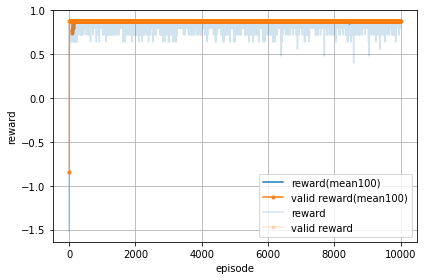

In [6]:
import srl
from srl.runner import sequence

config = sequence.Config(
    env_config=srl.envs.Config("MyEnv"),
    rl_config=srl.rl.ql.Config(),  # Q学習
)

# --- train
parameter, memory, history = sequence.train(config, max_episodes=10000)
history.plot()


In [7]:
rewards = sequence.evaluate(config, parameter, max_episodes=100)
print("100エピソードの平均結果", np.mean(rewards))


100エピソードの平均結果 0.88


In [8]:
reward, render = sequence.render(config, parameter, enable_animation=True)


### 0
X...P...G
  0: 0.42669
 *1: 0.62060
### 1, actions [1], rewards [-0.04], done False(), next [0]
X....P..G
env_info  : {}
work_info 0: None
train_info: None
  0: 0.51854
 *1: 0.73400
### 2, actions [1], rewards [-0.04], done False(), next [0]
X.....P.G
env_info  : {}
work_info 0: {}
train_info: None
  0: 0.62060
 *1: 0.86000
### 3, actions [1], rewards [-0.04], done False(), next [0]
X......PG
env_info  : {}
work_info 0: {}
train_info: None
  0: 0.73400
 *1: 1.00000
### 4, actions [1], rewards [1], done True(env), next [0]
X.......P
env_info  : {}
work_info 0: {}
train_info: None


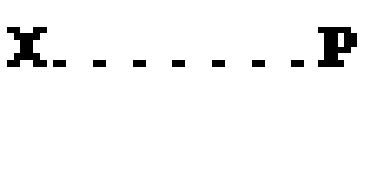

In [9]:
# render.create_anime(fps=1).save("MyEnv.gif")
render.display(fps=1)
